# CLV Prediction

**Business Problem**: 

Predict **6-month Customer Lifetime Value (CLV)** for each customer based on their historical transaction behavior from the [Online Retail](https://archive.ics.uci.edu/dataset/502/online+retail+ii) dataset, so a business can prioritize high-value customers for retention and marketing, and deploy a production-ready ML system with experiment tracking, orchestration, monitoring, and reproducibility.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 100)

In [3]:
print(os.getcwd())

C:\Users\diana\jupyter_notebooks\clv-prediction\notebooks


## Step 1: Load & Explore the Dataset

In [4]:
df = pd.read_excel("../data/raw/online_retail_II.xlsx", sheet_name="Year 2010-2011")

In [5]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


**Variable & Description**

- **Invoice**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 
- **StockCode**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. 
- **Description**: Product (item) name. Nominal. 
- **Quantity**: The quantities of each product (item) per transaction. Numeric.	
- **InvoiceDate**: Invice date and time. Numeric. The day and time when a transaction was generated. 
- **Price**: Unit price. Numeric. Product price per unit in sterling (£). 
- **Customer ID**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. 
- **Country**: Country name. Nominal. The name of the country where a customer resides.

In [6]:
df = df.rename(
    columns={
        "Invoice": "invoice",
        "StockCode": "stock_code",
        "Description": "description",
        "Quantity": "quantity",
        "InvoiceDate": "invoice_date",
        "Price": "price",
        "Customer ID": "customer_id",
        "Country": "country",
    }
)

In [7]:
df.shape

(541910, 8)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice       541910 non-null  object        
 1   stock_code    541910 non-null  object        
 2   description   540456 non-null  object        
 3   quantity      541910 non-null  int64         
 4   invoice_date  541910 non-null  datetime64[ns]
 5   price         541910 non-null  float64       
 6   customer_id   406830 non-null  float64       
 7   country       541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Step 2: Data Cleaning

In [9]:
# date range & time coverage
df["invoice_date"].min(), df["invoice_date"].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [10]:
# missing values
df.isna().mean().sort_values(ascending=False)

customer_id     0.249266
description     0.002683
invoice         0.000000
stock_code      0.000000
quantity        0.000000
invoice_date    0.000000
price           0.000000
country         0.000000
dtype: float64

In [11]:
# remove nulls
df = df.dropna(subset=["customer_id"])

In [12]:
# checking cancelled & invalid transactions
df.loc[:, "is_cancelled"] = df["invoice"].astype(str).str.startswith("C")

In [13]:
df["is_cancelled"].value_counts(normalize=True)

is_cancelled
False    0.978111
True     0.021889
Name: proportion, dtype: float64

In [14]:
# remove cancellation
df = df[~df["is_cancelled"]]

In [15]:
# quantity & price sanity checks
df[["quantity", "price"]].describe()

,quantity,price
count,397925.000000,397925.000000
mean,13.021793,3.116212
std,180.419984,22.096773
min,1.000000,0.000000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [16]:
df = df.loc[(df["quantity"] > 0) & (df["price"] > 0)].copy()

In [17]:
# create revenue column
df["revenue"] = df["quantity"] * df["price"]

## Step 3: Exploratory Data Analysis (EDA)

### Univariate Distributions

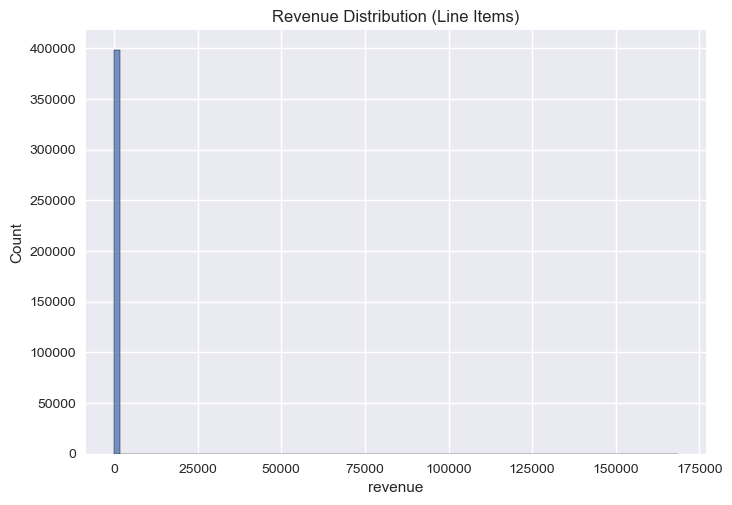

In [18]:
# revenue per line item
sns.histplot(df["revenue"], bins=100)
plt.title("Revenue Distribution (Line Items)")
plt.show()

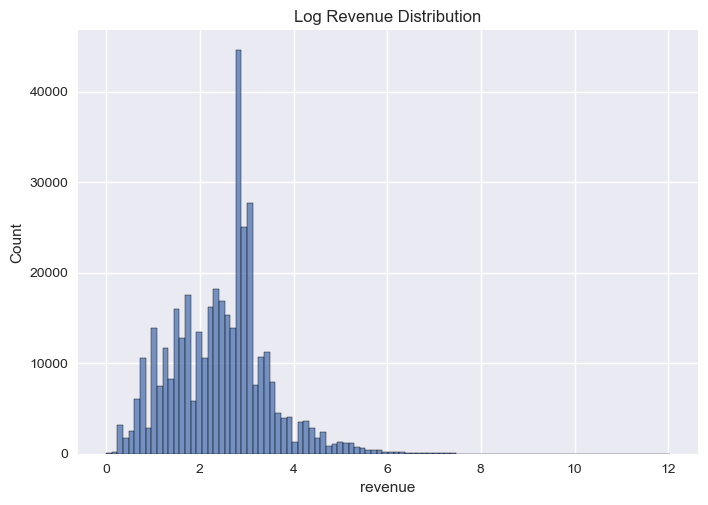

In [19]:
sns.histplot(np.log1p(df["revenue"]), bins=100)
plt.title("Log Revenue Distribution")
plt.show()

In [20]:
# customer-level aggregation
customer_summary = df.groupby("customer_id").agg(
    total_revenue=("revenue", "sum"),
    num_transactions=("invoice", "nunique"),
    first_purchase=("invoice_date", "min"),
    last_purchase=("invoice_date", "max"),
)

customer_summary.describe()

,total_revenue,num_transactions,first_purchase,last_purchase
count,4338.000000,4338.000000,4338,4338
mean,2054.270609,4.272015,2011-04-30 17:06:50.857538048,2011-09-08 11:38:59.045643008
min,3.750000,1.000000,2010-12-01 08:26:00,2010-12-01 09:53:00
25%,307.415000,1.000000,2011-01-17 11:13:15,2011-07-20 19:18:00
50%,674.485000,2.000000,2011-04-05 09:52:30,2011-10-20 10:40:30
75%,1661.740000,5.000000,2011-08-19 10:11:30,2011-11-22 11:05:45
max,280206.020000,209.000000,2011-12-09 12:16:00,2011-12-09 12:50:00
std,8989.229895,7.697998,NaN,NaN


In [21]:
# country distribution
df["country"].value_counts().head(10)

country
United Kingdom    354321
Germany             9040
France              8342
EIRE                7236
Spain               2484
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1462
Australia           1182
Name: count, dtype: int64

**Conclusion**:
- Dataset spans ~1 year of transactions with sufficient future horizon.
- ~25% of rows lack CustomerID and were removed.
- Cancelled and invalid transactions were filtered.
- Revenue distribution is highly skewed → log transforms likely needed.
- Customer behavior varies significantly in frequency and spend.

In [22]:
# save clean data
df.to_csv("../data/processed/online_retail_II_clean.csv", index=False)